# PDBe API Training

### PDBe Interactions

This tutorial will guide you through searching PDBe programmatically.


First we will import the code which will do the work
Run the cell below - by pressing the green play button.

In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import sys
sys.path.insert(0,'..') # to ensure the below import works in all Jupyter notebooks
from python_modules.api_modules import run_sequence_search, explode_dataset, get_ligand_site_data


Now we are ready to actually run the sequence search we did in the last module

We will search for a sequence with an example sequence from UniProt P24941 -
Cyclin-dependent kinase 2

In [3]:
sequence_to_search = """
MEDAKNIKKGPAPFYPLEDGTAGEQLHKAMKRYALVPGTIAFTDAHIEVNITYAEYFEMS
VRLAEAMKRYGLNTNHRIVVCSENSLQFFMPVLGALFIGVAVAPANDIYNERELLNSMNI
SQPTVVFVSKKGLQKILNVQKKLPIIQKIIIMDSKTDYQGFQSMYTFVTSHLPPGFNEYD
FVPESFDRDKTIALIMNSSGSTGLPKGVALPHRTACVRFSHARDPIFGNQIIPDTAILSV
VPFHHGFGMFTTLGYLICGFRVVLMYRFEEELFLR
SLQDYKIQSALLVPTLFSFFAKSTL
IDKYDLSNLHEIASGGAPLSKEVGEAVAKRFHLPGIRQGYGLTETTSAILITPEGDDKPG
AVGKVVPFFEAKVVDLDTGKTLGVNQRGELCVRGPMIMSGYVNNPEATNALIDKDGWLHS
GDIAYWDEDEHFFIVDRLKSLIKYKGYQVAPAELESILLQHPNIFDAGVAGLPDDDAGEL
PAAVVVLEHGKTMTEKEIVDYVASQVTTAKKLRGGVVFVDEVPKGLTGKLDARKIREILI
KAKKGGKSKL
"""
filter_list = ['pfam_accession', 'pdb_id', 'molecule_name', 'ec_number',
               'uniprot_accession_best', 'tax_id']

search_results = run_sequence_search(sequence_to_search,
                                     filter_terms=filter_list,
                                     number_of_rows=1000
                                     )

Number of results 222


Load the data into a Dataframe

In [4]:
df = explode_dataset(search_results)
df = df.query('percentage_identity > 80')
group_by_uniprot = df.groupby('uniprot_accession_best').count().sort_values('pdb_id', ascending=False)

How many UniProt accessions were there?

In [5]:
len(group_by_uniprot)

2

lets look at the data to see what we have

In [6]:
group_by_uniprot.head()

,chain_id,ec_number,entity_id,entry_entity,molecule_name,pdb_id,pfam_accession,tax_id,e_value,percentage_identity,result_sequence
uniprot_accession_best,,,,,,,,,,,
P08659,48,48,48,48,48,48,46,48,48,48,0
Q5UFR2,4,4,4,4,4,4,4,4,4,4,0


get the first UniProt from the results

In [7]:
uniprot_accession = df['uniprot_accession_best'].iloc[0]

uniprot_accession

'P08659'

Get compounds which interact with the UniProt

In [8]:
ligand_data = get_ligand_site_data(uniprot_accession=uniprot_accession)
df2 = explode_dataset(ligand_data)

https://www.ebi.ac.uk/pdbe/graph-api/uniprot/ligand_sites/P08659


Some post processing is required to separating interactingPDBEntries into separate columns

In [9]:
data = pd.json_normalize(df2['interactingPDBEntries'])
df3 = df2.join(data).drop(columns='interactingPDBEntries')


startIndex and endIndex are the UniProt residue number, so we'll make a new column called residue_number
and copy the startIndex there.
We are also going to "count" the number of results - so we'll make a dummy count column to store it in

In [10]:
df3['residue_number'] = df3['startIndex']
df3['count'] = df3['pdbId']

Now we are ready to use the data.

In [11]:
df3.head()

,startIndex,endIndex,startCode,endCode,indexType,allPDBEntries,ligand_accession,ligand_name,ligand_num_atoms,uniprot_accession,interaction_ratio,pdbId,entityId,chainIds,residue_number,count
0,316,316,GLY,GLY,UNIPROT,5gyz,AMP,ADENOSINE MONOPHOSPHATE,23,P08659,1.0,5gyz,1,A,316,5gyz
1,317,317,ALA,ALA,UNIPROT,5gyz,AMP,ADENOSINE MONOPHOSPHATE,23,P08659,1.0,5gyz,1,A,317,5gyz
2,318,318,PRO,PRO,UNIPROT,5gyz,AMP,ADENOSINE MONOPHOSPHATE,23,P08659,1.0,5gyz,1,A,318,5gyz
3,339,339,GLY,GLY,UNIPROT,5gyz,AMP,ADENOSINE MONOPHOSPHATE,23,P08659,1.0,5gyz,1,A,339,5gyz
4,340,340,TYR,TYR,UNIPROT,5gyz,AMP,ADENOSINE MONOPHOSPHATE,23,P08659,1.0,5gyz,1,A,340,5gyz


Ligands which interact with every entry have an interaction_ratio of 1.0.
So lets get them....

In [12]:
df4 = df3.groupby('ligand_accession')['interaction_ratio'].mean().reset_index()
ret = df4.query('interaction_ratio == 1.0')['ligand_accession'].values

In [23]:
ret

array(['0NJ', '5J4', '7V6', '923', 'AMP', 'CL', 'DYD', 'GKH', 'GOL',
       'M24', 'MBR', 'PEG', 'PG4', 'TLA', 'XLX'], dtype=object)

We have GOL (glycerol) and PEG in the list of ligands so this isn't enough to filter them

So, lets see if we can filter ligands by which ligands interact with the residues which have the most interactions.

First lets see how many interactions we have per residue.

In [13]:
df4 = df3.groupby('residue_number')['count'].count().reset_index()

<AxesSubplot:xlabel='residue_number', ylabel='count'>

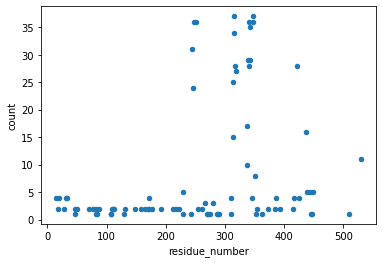

In [14]:
df4.plot.scatter(x='residue_number', y='count')

We can the determine the mean number of interactions

In [15]:
mean = df4.mean()
mean

residue_number    253.227273
count               8.602273
dtype: float64

We need to extract the mean value as a number from the above result

In [16]:
mean_value = float(mean.values[1])
mean_value

8.602272727272727

Then we can plot residues which have more interactions than the mean in red
and those which are equal to or below in blue.

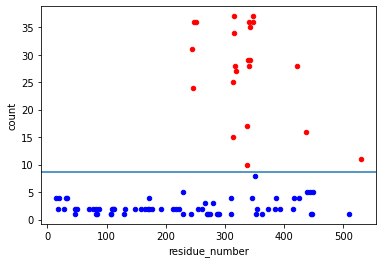

In [17]:
fig, ax = plt.subplots() # this makes one plot with an axis "ax" which we can add several plots to
df4.query('count <= {}'.format(mean_value)).plot.scatter(x='residue_number', y='count', color='blue', ax=ax)
df4.query('count > {}'.format(mean_value)).plot.scatter(x='residue_number', y='count', color='red', ax=ax)
ax.axhline(mean_value)
plt.show()
plt.close()

We can see the red interactions cluster around residue 250-400

The actual residues are

In [18]:
all_data_over_mean = df4.query('count > {}'.format(mean_value))
all_data_over_mean


,residue_number,count
36,245,31
37,246,24
38,247,36
39,251,36
52,313,15
53,314,25
54,315,37
55,316,34
56,317,28
57,318,27


we only want the residue numbers for the next step

In [19]:
residue_numbers_over_mean = all_data_over_mean['residue_number']
residue_numbers_over_mean

36    245
37    246
38    247
39    251
52    313
53    314
54    315
55    316
56    317
57    318
58    337
59    338
60    339
61    340
62    341
63    342
64    343
66    347
67    348
78    422
80    437
87    529
Name: residue_number, dtype: int64

What ligands interact with these residues?

Now we want to get all ligand_accessions which interact with a residue in "residue_numbers_over_mean"

In [20]:
df5  = df3[df3['residue_number'].isin(residue_numbers_over_mean)]['ligand_accession']
df5

0      AMP
1      AMP
2      AMP
3      AMP
4      AMP
      ... 
679    MBR
682    MBR
683    MBR
684    MBR
685    MBR
Name: ligand_accession, Length: 605, dtype: object

The same ligand appears several times so we an "unique" the list to get our list of ligands
which have a number of interactions over the mean interaction count.

In [23]:
interesting_ligands = list(df5.unique())
interesting_ligands

['AMP',
 '7V6',
 '0NJ',
 '7BV',
 '923',
 'M24',
 'GKH',
 'SLU',
 '5J4',
 'PG4',
 'DYD',
 'MBR']

It's worth seeing which ligands are not in our list

In [22]:
all_ligands = list(df3['ligand_accession'].unique())

missing_ligands = [x for x in all_ligands if x not in interesting_ligands]
missing_ligands

['GOL', 'CL', 'XLX', 'TLA', 'PEG', 'SO4', 'EDO']

Now we can display the interactions only for those ligands we have found

We will start with our Dataframe df3

In [24]:
df3.head()

,startIndex,endIndex,startCode,endCode,indexType,allPDBEntries,ligand_accession,ligand_name,ligand_num_atoms,uniprot_accession,interaction_ratio,pdbId,entityId,chainIds,residue_number,count
0,316,316,GLY,GLY,UNIPROT,5gyz,AMP,ADENOSINE MONOPHOSPHATE,23,P08659,1.0,5gyz,1,A,316,5gyz
1,317,317,ALA,ALA,UNIPROT,5gyz,AMP,ADENOSINE MONOPHOSPHATE,23,P08659,1.0,5gyz,1,A,317,5gyz
2,318,318,PRO,PRO,UNIPROT,5gyz,AMP,ADENOSINE MONOPHOSPHATE,23,P08659,1.0,5gyz,1,A,318,5gyz
3,339,339,GLY,GLY,UNIPROT,5gyz,AMP,ADENOSINE MONOPHOSPHATE,23,P08659,1.0,5gyz,1,A,339,5gyz
4,340,340,TYR,TYR,UNIPROT,5gyz,AMP,ADENOSINE MONOPHOSPHATE,23,P08659,1.0,5gyz,1,A,340,5gyz


We will select only ligands which interact the most in a Dataframe df6

In [25]:
df6 = df3.groupby(['residue_number', 'ligand_accession'])['interaction_ratio'].mean().reset_index()

We are going to scale the interactions as we use this later

In [26]:
df6['interaction_ratio'] = df6['interaction_ratio'].apply(lambda x: x*2)
df6

,residue_number,ligand_accession,interaction_ratio
0,15,EDO,2.0
1,18,EDO,1.0
2,19,EDO,2.0
3,28,EDO,1.0
4,32,EDO,2.0
...,...,...,...
216,447,XLX,2.0
217,448,SLU,0.4
218,509,XLX,2.0
219,529,GKH,2.0


Now we can plot the ligand interactions of those ligands which interact with the most interacting residues.

We will put each ligand on a row and scale the interactions by the percentage of PDB entries they are seen in.


C:\Users\jmb\Documents\software\git\pdbe\pdbe_jupyter\venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\jmb\Documents\software\git\pdbe\pdbe_jupyter\venv\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


<Figure size 720x1440 with 0 Axes>

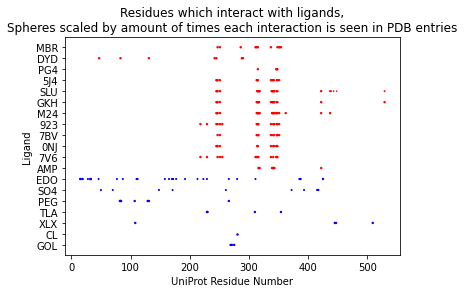

In [27]:
# prepare a figure
plt.figure(figsize=(10, 20))
fig, ax = plt.subplots()

# plot the less interesting ligands in blue
for ligand in missing_ligands:
    data = df6[df6['ligand_accession'] == ligand]
    y_data = [ligand] * len(data)
    data['y_data'] = y_data
    data.plot.scatter(x='residue_number', y='y_data', ax=ax, s='interaction_ratio', c='blue')

# plot the interesting ligands in red
for ligand in interesting_ligands:
    data = df6[df6['ligand_accession'] == ligand]
    y_data = [ligand] * len(data)
    data['y_data'] = y_data
    data.plot.scatter(x='residue_number', y='y_data', ax=ax, s='interaction_ratio', c='red')

plt.ylabel('Ligand')
plt.xlabel('UniProt Residue Number')
plt.title('Residues which interact with ligands,\nSpheres scaled by amount of times each interaction is seen in PDB entries')
plt.show()
plt.close()